In [1]:
%load_ext autoreload
%autoreload 2

In [235]:
import datasets
from data_analysis import (read_steering_results, plot_steering_results,read_steering_results_from_hub, 
    read_steering_results_from_hub_multiproc,DIR,MUTATIONS_RENAMED,all_subsets, conditional_prob)
from huggingface_hub import hf_hub_download,snapshot_download
import os
import sys
from scipy import stats
import pandas as pd
from collections import Counter
os.environ['PYTHONPATH'] = '/home/franlucc/projects/codetrace'
sys.path.insert(0, os.environ['PYTHONPATH'])
from itertools import combinations
from codetrace.fast_utils import *

os.environ["HF_HUB_DISABLE_PROGRESS_BARS"]="true"
datasets.disable_progress_bars()

In [3]:
#prefetch
cache_dir = snapshot_download(repo_id="nuprl-staging/type-steering-results", repo_type="dataset", local_dir="/tmp/cached_steering_results")
cache_dir

Fetching 821 files:   0%|          | 0/821 [00:00<?, ?it/s]

'/tmp/cached_steering_results'

In [4]:
qwen_results, missing_results = read_steering_results_from_hub_multiproc("py","qwen2p5_coder_7b_base",28,5, cache_dir = cache_dir, num_proc=40)
print(qwen_results, missing_results)

Applying: 100%|██████████| 42/42 [00:24<00:00,  1.73it/s]

    num_succ  tot_succ  mean_succ  rand_num_succ  rand_tot_succ  \
0          2       100       0.02              0            100   
0          5       100       0.05              0            100   
0          4       100       0.04              0            100   
0          9       100       0.09              0            100   
0          3       100       0.03              0            100   
..       ...       ...        ...            ...            ...   
0         67       100       0.67             10            100   
0          5       100       0.05             15            100   
0         10       100       0.10              9            100   
0         24       100       0.24             15            100   
0         64       100       0.64             14            100   

    rand_mean_succ  steering_num_succ  steering_tot_succ  steering_mean_succ  \
0             0.00               29.0              985.0            0.029442   
0             0.00              124

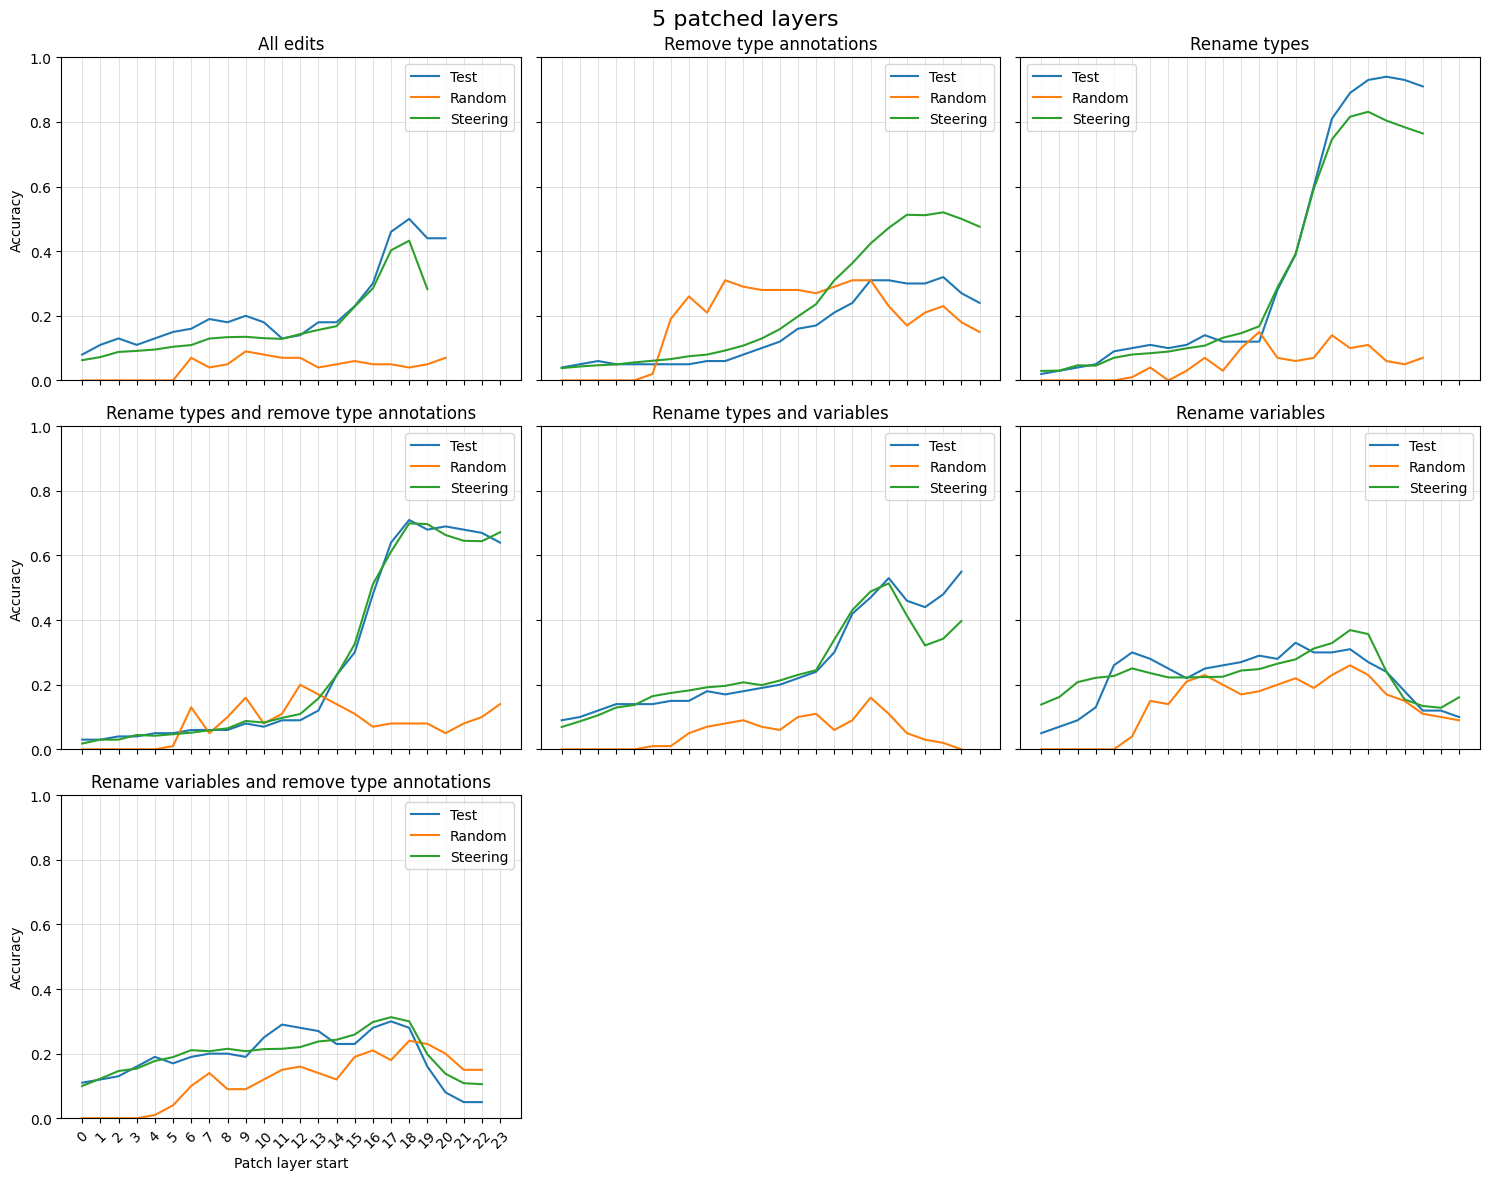

In [7]:
df_pretty = qwen_results.copy()
df_pretty["mutations"] = df_pretty["mutations"].apply(lambda x: MUTATIONS_RENAMED[x])
df_pretty = df_pretty.sort_values(["mutations","layers"])
plot_steering_results(df_pretty, 5)

In [78]:
ds = datasets.load_dataset("nuprl-staging/type-steering-results", "steering-py-vars_delete-17_18_19_20_21-qwen2p5_coder_7b_base")

0.31290322580645163 0.31290322580645163
['', 'Fixture', 'None', 'Result', 'Update', 'Section', 'M', 'Order', 'Monad', 'Logging', 'Abstract', 'Up', 'Foo', 'local', 'Agent', 'Merge', 'T', 'Explicit', 'Optional', 'View', 'ta', 'n', 'Frozen', 'Brand', 'Option', 'Service', 'Await', 'Custom', 'Axis', 'Base', 'ep', '_t', 'Delete', 'type', 'Client', 'R', 'Domin', 'Party', 'bool', 'Exception', 'Group', '_M', 'Async', 'Generator', 'ReadOnly', 'int', 'uuid', 'Sensor', 'Test', 'Documents', 'Site', 'Net', 'HttpRequest', 'Package', 'str', 'Edge', 'set', 'Configuration', 'models', 'tuple', 'Message', 'Renderer', '<|fim_pad|>', 'TypeInfo', 'Recv', 'VS', 'Undefined', 'Ke', 'frame', 'Bucket', 'date', 'Ticket', 'Event', 'driver', 'Response', 'Realm', 'Node', 'Command', 'dict', 'P', 'Board', 'sql', 'Schema', 'Mapping', 'Session', 'pytest', 'Input', 'Number', 'Statement', 'User', '_Data', 'UUID', 'schemas', 'Context', 'StreamReader', 'Never', 'Complex', 'fl', 'Path', 'HTML', 'object', 'path', 'Collection',

(<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>)

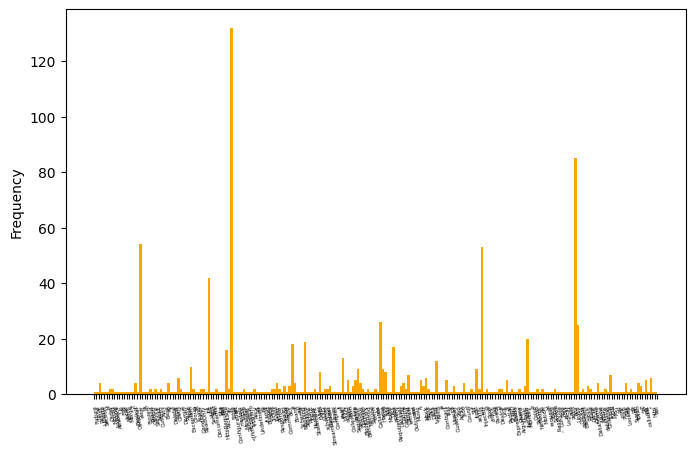

In [91]:
df_steer = ds["steer"].to_pandas()
df_test = ds["steer"].to_pandas()
df_test["succ"] = df_test["steered_predictions"] == df_test["fim_type"]
df_steer["succ"] = df_steer["steered_predictions"] == df_steer["fim_type"]
print(df_test["succ"].mean(), df_steer["succ"].mean())
df_test["steer_direction"] = df_test["mutated_generated_text"] + "->" + df_test["fim_type"]
df_steer["steer_direction"] = df_steer["mutated_generated_text"] + "->" + df_steer["fim_type"]

compare = "mutated_generated_text"

all_labels = []
for df in [df_steer, df_test]:
    all_labels += list(df[compare])
all_labels = list(set(all_labels))

FIM_TO_ID = {}
for i,label in enumerate(all_labels):
    FIM_TO_ID[str(label)] = i
fim_to_id = (lambda x: FIM_TO_ID[str(x)])

df_test["fim_type_id"] = df_test[compare].apply(fim_to_id)
df_steer["fim_type_id"] = df_steer[compare].apply(fim_to_id)

df_test_succ = df_test[df_test["succ"]]
labels = sorted(all_labels, key=(lambda x: FIM_TO_ID[x]))
print(labels)
ax_steer = df_steer["fim_type_id"].plot.hist(bins=len(labels), figsize=(8, 5))
ax_steer.set_xticks(range(len(labels)))
ax_steer.set_xticklabels(labels,rotation=100, fontsize=4)

ax_test = df_test["fim_type_id"].plot.hist(bins=len(labels), figsize=(8, 5), color="orange")
ax_test.set_xticks(range(len(labels)))
ax_test.set_xticklabels(labels,rotation=100, fontsize=4)

ax_steer, ax_test

<Axes: ylabel='Frequency'>

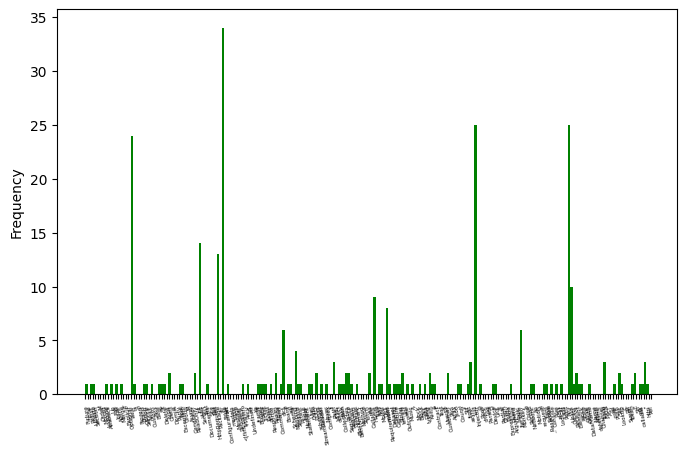

In [92]:
ax_test_succ = df_test_succ["fim_type_id"].plot.hist(bins=len(labels), figsize=(8, 5), color="green")
ax_test_succ.set_xticks(range(len(labels)))
ax_test_succ.set_xticklabels(labels,rotation=100, fontsize=4)


ax_test_succ


<Axes: ylabel='Frequency'>

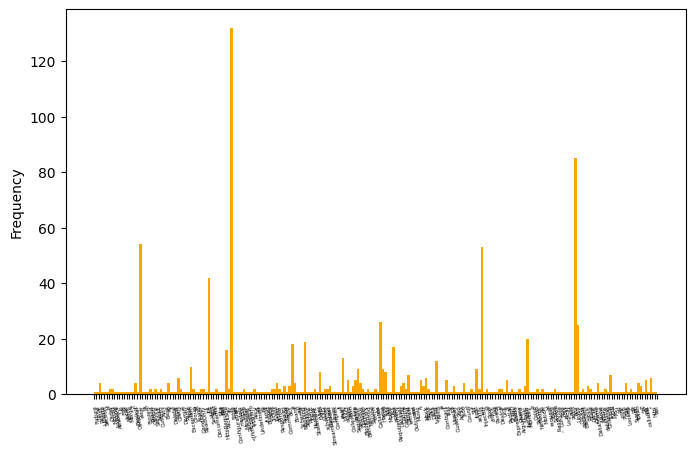

In [93]:
ax_test = df_test["fim_type_id"].plot.hist(bins=len(labels), figsize=(8, 5), color="orange")
ax_test.set_xticks(range(len(labels)))
ax_test.set_xticklabels(labels,rotation=100, fontsize=4)
ax_test

What is performance dependent on? Confounding variables?

fim_type frequency in steer vs test
mutated_generated_text (error) frequency in steer vs test

hypothesis: if fim_type/mutated_generated_text is not well represented in steer, then performance will be low

methodology:
- get all the unique values of fim_type/mutated_generated_text in steer and test
- get the frequency of each value in steer and test
- compare the frequency of each value in steer and test
- if the frequency of a value in steer is low, then the performance will be low


In [ ]:
columns=[
    'fim_type_test', 
    'mutated_generated_text_test', 
    'frequency_fim_type_steer',
    'frequency_mutated_generated_text_steer', 
    'success_test',
    'layers_test',
    'mutation_names_test'
    ]

all_datasets = []
for m,l in [("qwen2p5_coder_7b_base",28)]:#,("CodeLlama-7b-Instruct-hf",32)]:
    all_datasets += all_subsets("py",m,l,5)

def process_batch(data):
    correlation_df = []
    for ds_name in data:
        layers = ds_name.split("-")[3]
        try:
            ds = datasets.load_dataset("nuprl-staging/type-steering-results", ds_name)
        except Exception as e:
            print(e)
            continue
        
        try:
            df_steer = ds["steer"].to_pandas()
        except:
            print("Steer not found", ds_name)
            continue
        df_test = ds["test"].to_pandas()
        df_test["layers"] = int(layers.split("_")[0])
        df_test["success"] = df_test["fim_type"] == df_test["steered_predictions"]
        df_test.columns = [f"{c}_test" for c in df_test.columns]
        frequency_steer_mg = df_steer["mutated_generated_text"].value_counts().to_dict()
        frequency_steer_ft = df_steer["fim_type"].value_counts().to_dict()
        df_test["success_rate"] = df_test["fim_type_test"] == df_test["steered_predictions_test"]
        df_test["frequency_fim_type_steer"] = df_test["fim_type_test"].apply(lambda x: frequency_steer_ft.get(x, 0))
        df_test["frequency_mutated_generated_text_steer"] = df_test["mutated_generated_text_test"].apply(lambda x: frequency_steer_mg.get(x, 0))
        correlation_df.append(df_test[columns])
    return correlation_df

batches = make_batches(all_datasets, 40)
results = batched_apply(batches, 40, process_batch)
correlation_df = pd.concat(results, axis=0)


In [237]:
correlation_df["mutation_names_test"] = correlation_df["mutation_names_test"].apply(lambda x: "".join(x))
value_counts = correlation_df.groupby(["mutation_names_test"]).agg({"frequency_fim_type_steer": (lambda x: Counter(x))}).reset_index()
value_counts.to_csv("val_counts.csv")

In [ ]:
# stats.pearsonr(correlation_df["success_test"], correlation_df["layers_test"])
for i in range(28):
    label=f"start_{i}"
    correlation_df[label] = correlation_df["layers_test"] == i
    a,b,anb,agb = conditional_prob("success_test", label,correlation_df)
    print(f"{label} = {agb}, {correlation_df[label].sum()}")

step=3
for i in range(0, 25, step):
    label = f"freq_ft_{i}_{i+step}"
    correlation_df[label] = correlation_df["frequency_fim_type_steer"].apply(lambda x: x >= i and x < i+step)
    a,b,anb,agb = conditional_prob("success_test", label,correlation_df)
    print(f"{label} = {agb}, {correlation_df[label].sum()}")

for i in range(0, 25, step):
    label = f"freq_mg_{i}_{i+step}"
    correlation_df[label] = correlation_df["frequency_mutated_generated_text_steer"].apply(lambda x: x >= i and x < i+step)
    a,b,anb,agb = conditional_prob("success_test", label,correlation_df)
    print(f"{label} = {agb}, {correlation_df[label].sum()}")

correlation_df["success_test"].mean()

start_0 = 0.060000000000000005, 700
start_1 = 0.07285714285714286, 700
start_2 = 0.08714285714285715, 700
start_3 = 0.09714285714285716, 700
start_4 = 0.13, 700
start_5 = 0.13714285714285715, 700
start_6 = 0.14285714285714288, 700
start_7 = 0.14285714285714288, 700
start_8 = 0.1442857142857143, 700
start_9 = 0.15571428571428572, 700
start_10 = 0.16285714285714287, 700
start_11 = 0.17, 700
start_12 = 0.17714285714285716, 700
start_13 = 0.21571428571428572, 700
start_14 = 0.25285714285714284, 700
start_15 = 0.31, 700
start_16 = 0.40428571428571425, 700
start_17 = 0.48285714285714293, 700
start_18 = 0.5042857142857143, 700
start_19 = 0.46, 700
start_20 = 0.4366666666666667, 600
start_21 = 0.4266666666666667, 600
start_22 = 0.332, 500
start_23 = 0.3266666666666667, 300
start_24 = 0, 0
start_25 = 0, 0
start_26 = 0, 0
start_27 = 0, 0
freq_ft_0_3 = 0.23474436503573393, 1819
freq_ft_3_6 = 0.3547671840354767, 451
freq_ft_6_9 = 0.35294117647058826, 187
freq_ft_9_12 = 0.14285714285714285, 224
fre

0.2374375

In [ ]:

data = []
step=1
for start in range(28):
    for freq in range(0, 25, step):    
        label = f"freq_ft_{freq}_{freq+step}"
        correlation_df[label] = correlation_df["frequency_fim_type_steer"].apply(lambda x: x >= freq and x < freq+step)
    
        correlation_df["ft_freq_and_layer"] = correlation_df[f"start_{start}"] & (correlation_df[label])
        a,b,anb,agb = conditional_prob("success_test","ft_freq_and_layer", correlation_df)
        data.append({
            "start":start,
            "freq":freq,
            "agb":agb,
            "tot":correlation_df["ft_freq_and_layer"].sum(),
            "muts": "all"
        })
        for muts in set(["".join(m) for m in correlation_df["mutation_names_test"]]):
            _df = correlation_df[correlation_df["mutation_names_test"] == muts]
            a,b,anb,agb = conditional_prob("success_test","ft_freq_and_layer", _df)
            data.append({
                "start":start,
                "freq":freq,
                "agb":agb,
                "tot":_df["ft_freq_and_layer"].sum(),
                "muts": muts
            })
        

df_data = pd.DataFrame(data)
df_data[df_data["tot"] > 15]

,start,freq,agb,tot,muts
0,0,0,0.083333,48,all
8,0,1,0.105263,19,all
192,0,24,0.054054,555,all
193,0,24,0.060241,83,delete_annotationsrename_varsrename_types
194,0,24,0.082192,73,rename_typesrename_vars
...,...,...,...,...,...
4600,23,0,0.476190,21,all
4792,23,24,0.295833,240,all
4797,23,24,0.077922,77,rename_vars
4798,23,24,0.623377,77,rename_typesdelete_annotations


In [221]:
df_ = df_data[df_data["tot"] > 15]
df_[df_["agb"] > 0.5]

,start,freq,agb,tot
400,16,0,0.562500,48
401,16,1,0.578947,19
425,17,0,0.645833,48
426,17,1,0.684211,19
450,18,0,0.645833,48
451,18,1,0.631579,19
475,19,0,0.520833,48
500,20,0,0.534884,43


In [218]:
df_data

,start,freq,agb,tot
0,0,0,0.083333,48
1,0,1,0.105263,19
2,0,2,0.000000,12
3,0,3,0.125000,8
4,0,4,0.142857,7
...,...,...,...,...
695,27,20,0.000000,0
696,27,21,0.000000,0
697,27,22,0.000000,0
698,27,23,0.000000,0


In [230]:
df_data.sort_values(["muts","start","freq"]).to_csv("qwen.csv")